In [1]:
# Required Packages
import pandas as pd
import missingno as msno
import numpy as np

import copy
import unicodedata

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Plots

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Movie Recommendation System (Modeling)

[Here](https://hatefdastour.github.io/portfolio/recommendation_system/Movie_Recommendation_system_Preprocessing.html), we have already cleaned the data available from Kaggle.com ([link to Data](https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset)). In this article, a model using is developed that recommended a number of movies for a given movie title (from the available titles in the data).


#### Table of contents
* [Initial Analysis](#Initial-Analysis)
* [Modeling](#Modeling)
* [Movie Recommendations](#Movie-Recommendations)

#### Loading the preprocessed data

In [2]:
Data = pd.read_csv('Data/clean_movie_metadata.csv')

## Initial Analysis

The columns of the data:

In [3]:
Columns=Data.columns.tolist()
print(Columns)

['Actor_1_Facebook_Likes', 'Actor_1_Name', 'Actor_2_Facebook_Likes', 'Actor_2_Name', 'Actor_3_Facebook_Likes', 'Actor_3_Name', 'Budget', 'Cast_Total_Facebook_Likes', 'Color', 'Content_Rating', 'Country', 'Director_Facebook_Likes', 'Director_Name', 'Duration', 'Genres', 'Gross', 'IMDB_Score', 'Language', 'Movie_Facebook_Likes', 'Movie_Title', 'Num_Critic_For_Reviews', 'Num_User_For_Reviews', 'Num_Voted_Users', 'Plot_Keywords', 'Title_Year']


In [4]:
Ratings=Data[['Movie_Title','Gross','IMDB_Score','Num_Critic_For_Reviews', 'Num_User_For_Reviews']]
Ratings.sort_values(by='Gross', ascending=False).head(10).style.hide_index()

Movie_Title,Gross,IMDB_Score,Num_Critic_For_Reviews,Num_User_For_Reviews
Avatar,760505847.000000,7.900000,723.000000,3054.000000
Titanic,658672302.000000,7.700000,315.000000,2528.000000
Jurassic World,652177271.000000,7.000000,644.000000,1290.000000
The Avengers,623279547.000000,8.100000,703.000000,1722.000000
The Dark Knight,533316061.000000,9.000000,645.000000,4667.000000
Star Wars: Episode I - The Phantom Menace,474544677.000000,6.500000,320.000000,3597.000000
Star Wars: Episode IV - A New Hope,460935665.000000,8.700000,282.000000,1470.000000
Avengers: Age of Ultron,458991599.000000,7.500000,635.000000,1117.000000
The Dark Knight Rises,448130642.000000,8.500000,813.000000,2701.000000
Shrek 2,436471036.000000,7.200000,205.000000,483.000000


In [5]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr()
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdBu", n_colors=10), linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .5})
    bottom, top = ax.get_ylim()

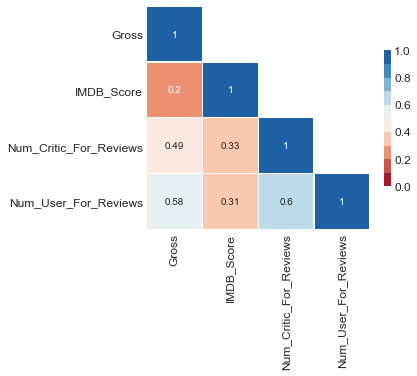

In [6]:
Rew_col_list=['Gross','IMDB_Score','Num_Critic_For_Reviews', 'Num_User_For_Reviews']
Correlation_Plot (Ratings[Rew_col_list],5)

It can be seen that both **the number of critics for reviews** and **the number of users for reviews** are highly correlated with **gross**.

Univariate plots:

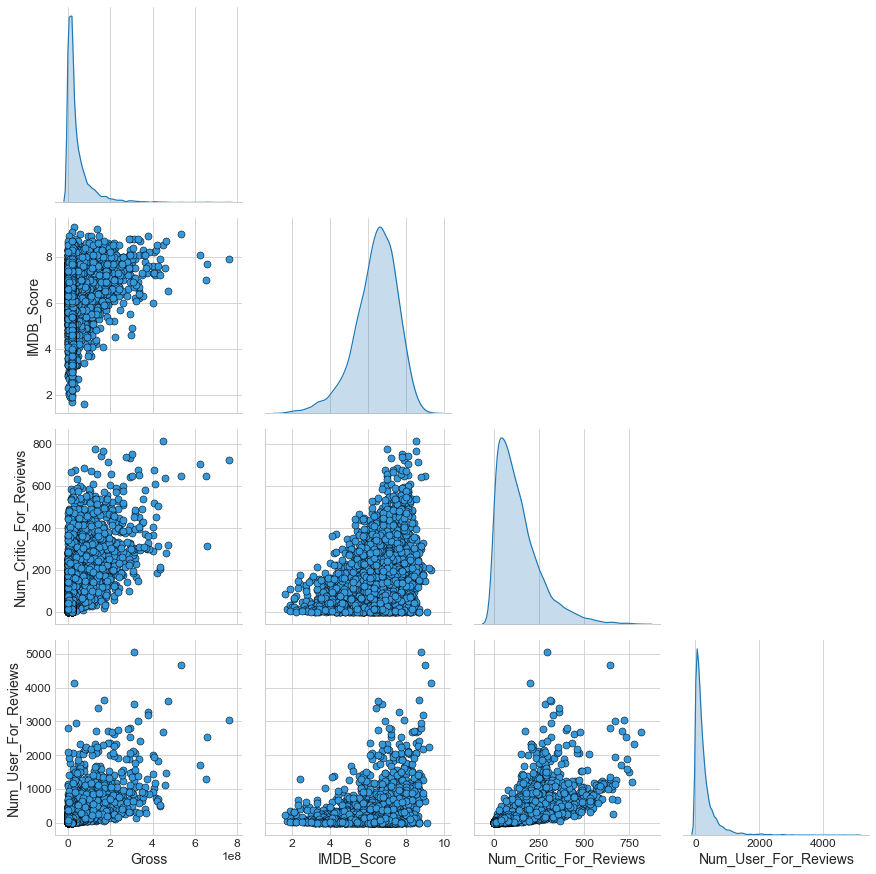

In [7]:
_ = sns.pairplot(Ratings, height=3.0, diag_kind="kde", 
             plot_kws=dict(s=50, color="#3498db", edgecolor="k", linewidth=0.5),
             diag_kws=dict(shade=True), corner=True)

We can see that **the number of critics for reviews** and **the number of users for reviews** are highly correlated.

## Modeling

We would like to convert the data into only two columns. That is one column only the movie titles and the other one all relevant information about a movie. Since we don't have any information on users' performance. This is a way to model this data.

In [8]:
Drop_List=list()

for i in range(len(Columns)):
    if Columns[i].find('Facebook') != -1:
        Drop_List.append(Columns[i])
    if Columns[i].find('Num') != -1:
        Drop_List.append(Columns[i])
## Adding the rest of unrelated columns to the drop list       
Drop_List=Drop_List+['Budget','Duration','Gross','IMDB_Score']

In [9]:
Data=Data.drop(columns=Drop_List)

This, the date reduces to

In [10]:
Data = Data.reindex(columns=sorted(Data.columns,reverse=True))
Data.head().style.hide_index()

Title_Year,Plot_Keywords,Movie_Title,Language,Genres,Director_Name,Country,Content_Rating,Color,Actor_3_Name,Actor_2_Name,Actor_1_Name
2009.000000,avatar|future|marine|native|paraplegic,Avatar,English,Action|Adventure|Fantasy|Sci-Fi,James Cameron,USA,PG-13,Color,Wes Studi,Joel David Moore,CCH Pounder
2007.000000,goddess|marriage ceremony|marriage proposal|pirate|singapore,Pirates of the Caribbean: At World's End,English,Action|Adventure|Fantasy,Gore Verbinski,USA,PG-13,Color,Jack Davenport,Orlando Bloom,Johnny Depp
2015.000000,bomb|espionage|sequel|spy|terrorist,Spectre,English,Action|Adventure|Thriller,Sam Mendes,UK,PG-13,Color,Stephanie Sigman,Rory Kinnear,Christoph Waltz
2012.000000,deception|imprisonment|lawlessness|police officer|terrorist plot,The Dark Knight Rises,English,Action|Thriller,Christopher Nolan,USA,PG-13,Color,Joseph Gordon-Levitt,Christian Bale,Tom Hardy
2012.000000,alien|american civil war|male nipple|mars|princess,John Carter,English,Action|Adventure|Sci-Fi,Andrew Stanton,USA,PG-13,Color,Polly Walker,Samantha Morton,Daryl Sabara


Converting the Data to string.

In [11]:
Data=Data.astype(str)

More modifications on `genres` anc `plot_keywords` columns:

In [12]:
### Genres
# converting to lower case
Data.Genres = Data.Genres.map(lambda x: x.lower())
# replacing '|' with ','
Data.Genres = Data.Genres.map(lambda x: x.split('|'))
# joining the string
Data.Genres = Data.Genres.str.join(' ') 

### Plot_Keywords
# converting to lower case
Data.Plot_Keywords = Data.Plot_Keywords.map(lambda x: x.lower())
# replacing '|' with ','
Data.Plot_Keywords = Data.Plot_Keywords.map(lambda x: x.split('|'))
Data.Plot_Keywords = Data.Plot_Keywords.str.join(' ') 

The resulting Data

In [13]:
Data.head().style.hide_index()

Title_Year,Plot_Keywords,Movie_Title,Language,Genres,Director_Name,Country,Content_Rating,Color,Actor_3_Name,Actor_2_Name,Actor_1_Name
2009.0,avatar future marine native paraplegic,Avatar,English,action adventure fantasy sci-fi,James Cameron,USA,PG-13,Color,Wes Studi,Joel David Moore,CCH Pounder
2007.0,goddess marriage ceremony marriage proposal pirate singapore,Pirates of the Caribbean: At World's End,English,action adventure fantasy,Gore Verbinski,USA,PG-13,Color,Jack Davenport,Orlando Bloom,Johnny Depp
2015.0,bomb espionage sequel spy terrorist,Spectre,English,action adventure thriller,Sam Mendes,UK,PG-13,Color,Stephanie Sigman,Rory Kinnear,Christoph Waltz
2012.0,deception imprisonment lawlessness police officer terrorist plot,The Dark Knight Rises,English,action thriller,Christopher Nolan,USA,PG-13,Color,Joseph Gordon-Levitt,Christian Bale,Tom Hardy
2012.0,alien american civil war male nipple mars princess,John Carter,English,action adventure sci-fi,Andrew Stanton,USA,PG-13,Color,Polly Walker,Samantha Morton,Daryl Sabara


Mimicing the process for actors and directors names:

In [14]:
for i in range(len(Columns)):
    if Columns[i].find('Name') != -1:
        Data[Columns[i]] = Data[Columns[i]].map(lambda x: x.split(' '))
        Data[Columns[i]] = Data[Columns[i]].str.join('')

In [15]:
Data.head().style.hide_index()

Title_Year,Plot_Keywords,Movie_Title,Language,Genres,Director_Name,Country,Content_Rating,Color,Actor_3_Name,Actor_2_Name,Actor_1_Name
2009.0,avatar future marine native paraplegic,Avatar,English,action adventure fantasy sci-fi,JamesCameron,USA,PG-13,Color,WesStudi,JoelDavidMoore,CCHPounder
2007.0,goddess marriage ceremony marriage proposal pirate singapore,Pirates of the Caribbean: At World's End,English,action adventure fantasy,GoreVerbinski,USA,PG-13,Color,JackDavenport,OrlandoBloom,JohnnyDepp
2015.0,bomb espionage sequel spy terrorist,Spectre,English,action adventure thriller,SamMendes,UK,PG-13,Color,StephanieSigman,RoryKinnear,ChristophWaltz
2012.0,deception imprisonment lawlessness police officer terrorist plot,The Dark Knight Rises,English,action thriller,ChristopherNolan,USA,PG-13,Color,JosephGordon-Levitt,ChristianBale,TomHardy
2012.0,alien american civil war male nipple mars princess,John Carter,English,action adventure sci-fi,AndrewStanton,USA,PG-13,Color,PollyWalker,SamanthaMorton,DarylSabara


Converting the data to two columns only, `Movie_Title` and `Other`

In [16]:
X = 'Movie_Title'
Y=list()
temp=Data.columns.tolist()
for i in range(len(temp)):
    if temp[i].find('Movie_Title') == -1:
         Y.append(temp[i])
del temp

In [17]:
Data['Other']=Data[Y[0]].astype(str)
for i in np.arange(1,len(Y)):
    Data['Other'] = Data['Other']+" "+ Data[Y[i]].astype(str)
del i

Droping Y columns

In [18]:
Data=Data.drop(columns=Y)
del X, Y

In [19]:
Data.head().style.hide_index()

Movie_Title,Other
Avatar,2009.0 avatar future marine native paraplegic English action adventure fantasy sci-fi JamesCameron USA PG-13 Color WesStudi JoelDavidMoore CCHPounder
Pirates of the Caribbean: At World's End,2007.0 goddess marriage ceremony marriage proposal pirate singapore English action adventure fantasy GoreVerbinski USA PG-13 Color JackDavenport OrlandoBloom JohnnyDepp
Spectre,2015.0 bomb espionage sequel spy terrorist English action adventure thriller SamMendes UK PG-13 Color StephanieSigman RoryKinnear ChristophWaltz
The Dark Knight Rises,2012.0 deception imprisonment lawlessness police officer terrorist plot English action thriller ChristopherNolan USA PG-13 Color JosephGordon-Levitt ChristianBale TomHardy
John Carter,2012.0 alien american civil war male nipple mars princess English action adventure sci-fi AndrewStanton USA PG-13 Color PollyWalker SamanthaMorton DarylSabara


Instantiating and generating the count matrix using [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [20]:
vectorizer = CountVectorizer()
Matrix= vectorizer.fit_transform(Data['Other'])
# to view the entries run the following command
# vectorizer.get_feature_names()

Next, we are going to use [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to find similarities.

In [21]:
Similarity_Matrix = cosine_similarity(Matrix, dense_output=True)
Similarity_Matrix

array([[1.        , 0.38138504, 0.31622777, ..., 0.17320508, 0.29880715,
        0.17888544],
       [0.38138504, 1.        , 0.30151134, ..., 0.16514456, 0.28490144,
        0.17056057],
       [0.31622777, 0.30151134, 1.        , ..., 0.18257419, 0.25197632,
        0.14142136],
       ...,
       [0.17320508, 0.16514456, 0.18257419, ..., 1.        , 0.41403934,
        0.15491933],
       [0.29880715, 0.28490144, 0.25197632, ..., 0.41403934, 1.        ,
        0.21380899],
       [0.17888544, 0.17056057, 0.14142136, ..., 0.15491933, 0.21380899,
        1.        ]])

## Movie Recommendations

In [22]:
def recommend_movies(title, Number_Of_Recommendations= 10, Sim_Matrix=Similarity_Matrix):
    # Recommended Movies List 
    Recommended_Movies_List  = []
    
    # the index of 'title' from the dataframe
    title_index = Data[Data['Movie_Title'].str.match(title)].index[0]
    
    # 'title' matches in descending order
    Title_Matches = pd.Series(Sim_Matrix[title_index]).sort_values(ascending = False)

    # Picking Number_Of_Recommendations movies
    Recom_index = list(Title_Matches.iloc[1:Number_Of_Recommendations].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in Recom_index:
        Recommended_Movies_List.append(list(Data.Movie_Title)[i].replace(u'\xa0', u''))
    
    Recommended_Movies_List=pd.DataFrame(Recommended_Movies_List,
                                         columns=['Recommended Titles']).style.hide_index()    
    return Recommended_Movies_List

For example, consider **The Dark Knight**. For this movie, the following ten movies are recommended.

In [23]:
recommend_movies('The Dark Knight')

Recommended Titles
Premium Rush
Inception
The One
Live Free or Die Hard
Man on a Ledge
Alex Cross
The Cold Light of Day
G.I. Joe: The Rise of Cobra
Jack Reacher


***